Loading data and libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mushrooms = pd.read_csv("mushrooms.csv")

Based on EDA, I will be dropping **"veil-type"**, **"stalk-root"** columns.  
While I could have built a prediction model to predict missing values of **"stalk-root"**, I decided to skip it for now  
Then I will be using encoding to get integer data

# Preprocessing functions

Ref : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html  
Note : a one-hot encoding of y labels should use a LabelBinarizer instead.

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix

def drop_features(data):
    '''
    Drops veil-type as it has only 1 value
    Drops stalk-root as it has a lot of missing values
    '''
    data = data.drop(['class', 'stalk-root', 'veil-type'], axis=1)
    return data


def label_encoding(data):
    '''Converts object type to integer type'''
    le = LabelEncoder()
    return data.apply(le.fit_transform)


def onehot_encoding(data):
    '''Returns a sparse matrix of the data'''
    ohe = OneHotEncoder()
    ohe.fit(data)
    return ohe.transform(data)


# labelbinariser must be used to encode target values
def label_binarizer(data):
    lb = LabelBinarizer()
    return lb.fit_transform(data)


def confmat(cfm):
    '''Returns a plot from a confusion matrix'''
    ax = sns.heatmap(cfm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['Edible','Poisonous'])
    ax.yaxis.set_ticklabels(['Edible','Poisonous'])
    plt.show()

In [3]:
X = drop_features(mushrooms)
y = mushrooms['class']

X_le = label_encoding(X)
X_encoded = onehot_encoding(X_le)
y_encoded = label_binarizer(y)

# Logistic Regression

In [4]:
# https://stackoverflow.com/questions/46598301/how-to-compute-precision-recall-and-f1-score-of-an-imbalanced-dataset-for-k-fold

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
model_LR= LogisticRegression()


scoring = ('accuracy', 'precision', 'recall', 'f1')

results = cross_validate(estimator=model_LR, 
                         X=X_encoded, 
                         y=y_encoded.ravel(), 
                         cv=skf, scoring = scoring)

scores = pd.DataFrame(list(zip(results['test_accuracy'], 
                               results['test_precision'], 
                               results['test_recall'], 
                               results['test_f1'])), 
                      columns =['Accuracy', 'Precision', 'Recall', 'F1 Score'], 
                      index = ('Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'))

scores

,Accuracy,Precision,Recall,F1 Score
Fold 1,1.000000,1.0,1.000000,1.000000
Fold 2,0.999385,1.0,0.998723,0.999361
Fold 3,1.000000,1.0,1.000000,1.000000
Fold 4,0.999385,1.0,0.998723,0.999361
Fold 5,1.000000,1.0,1.000000,1.000000


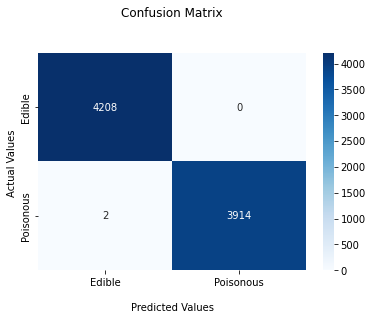

In [5]:
y_pred = cross_val_predict(model_LR, X_encoded, y_encoded, cv=skf, n_jobs=-1)
conf_mat = confusion_matrix(y_encoded, y_pred)

confmat(conf_mat)

The simple Linear regression model is performing really well with a mean accuracy of **0.99976**  
And it has a perfect Precision score but not a perfect Recall  
Which means, it is predicting Poisonous shrooms as edible (2 out of 3916 times)  
**False Negatives are not acceptable !**

I've learnt that I can penalize False negative prediction and implemented weighted LR.   
I used this reference : https://developpaper.com/using-class-weight-to-improve-class-imbalance/  
But the overall F1 score was deteriorating.
So I decided to move on to another model.

# Decision Tree Classifier

In [6]:
from sklearn.tree import DecisionTreeClassifier

model_DT= DecisionTreeClassifier(random_state=0)

results = cross_validate(estimator=model_DT, 
                         X=X_encoded, 
                         y=y_encoded.ravel(), 
                         cv=skf, scoring = scoring)

scores = pd.DataFrame(list(zip(results['test_accuracy'], 
                               results['test_precision'], 
                               results['test_recall'], 
                               results['test_f1'])), 
                      columns =['Accuracy', 'Precision', 'Recall', 'F1 Score'], 
                      index = ('Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'))

scores

,Accuracy,Precision,Recall,F1 Score
Fold 1,1.0,1.0,1.0,1.0
Fold 2,1.0,1.0,1.0,1.0
Fold 3,1.0,1.0,1.0,1.0
Fold 4,1.0,1.0,1.0,1.0
Fold 5,1.0,1.0,1.0,1.0


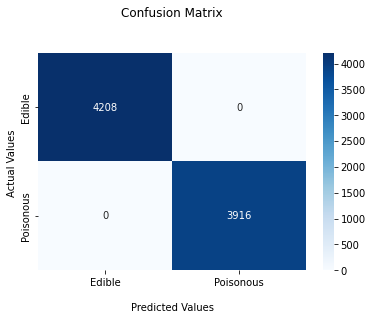

In [7]:
y_pred_2 = cross_val_predict(model_DT, X_encoded, y_encoded.ravel(), cv=skf, n_jobs=-1)
conf_mat_2 = confusion_matrix(y_encoded, y_pred_2)

confmat(conf_mat_2)

Now we have a perfect F1 score.  
I dont think I would need anymore models  
Let's see what the features were given more importance in this Decision tree

Reference : https://machinelearningmastery.com/calculate-feature-importance-with-python/

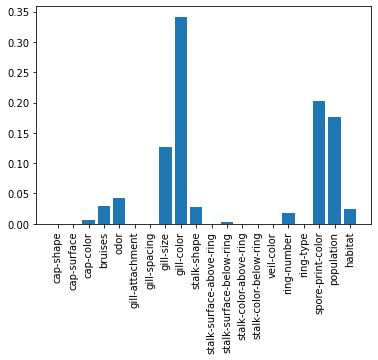

In [32]:
# plot feature importance
model_DT.fit(X_le, y_encoded)
plt.bar(X.columns, model_DT.feature_importances_)
plt.xticks(rotation=90)
plt.show()

**'gill-color' ; 'spore-print-color' ; 'population' ; 'gill-size'** seem to be the deciding features here  

Lets have a look at the top 3 rows of the tree

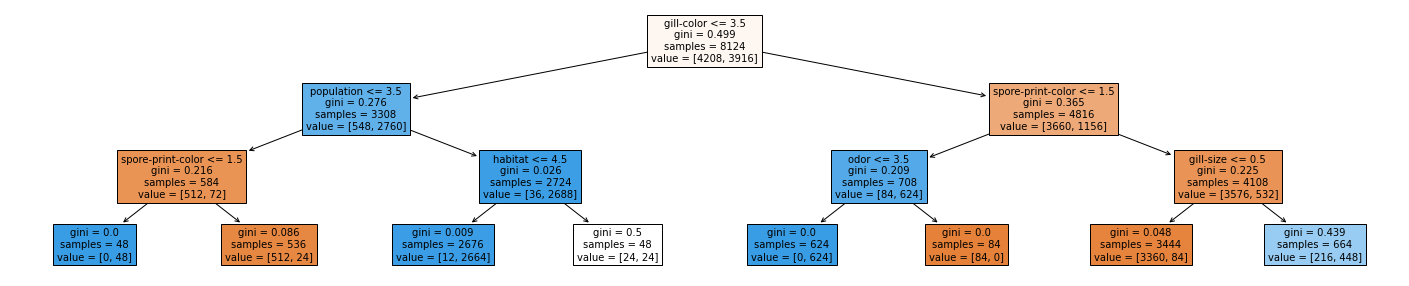

In [54]:
from sklearn import tree

features = list(X.columns.values)
model_DT = DecisionTreeClassifier(max_depth=3)
model_DT.fit(X_le, y_encoded)
fig = plt.figure(figsize=(25,5))
_ = tree.plot_tree(model_DT, 
                   feature_names=features,  
                   filled=True,
                   fontsize=10)

# Reference : https://stackoverflow.com/questions/59447378/sklearn-plot-tree-plot-is-too-small

# END